In [1]:
import argparse
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import jax
from jax.experimental.ode import build_odeint
import jax.numpy as np
from jax.random import PRNGKey
from jax import lax

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

## Deterministic model

In [85]:
def dx_dt( x, t, beta, sigma, gamma):
        """
        SEIR equations
        """        
        S, E, I, R, C = x
        N = S + E + I + R
        
        dS_dt = - beta * S * I / N
        dE_dt = beta * S * I / N - sigma * E
        dI_dt = sigma * E - gamma * I
        dR_dt = gamma * I
        dC_dt = sigma * E  # cumulative infections
        
        return np.stack([dS_dt, dE_dt, dI_dt, dR_dt, dC_dt])

SIR_int = build_odeint(dx_dt, rtol=1e-5, atol=1e-3, mxstep=500)



## Current model: SIR model for new cases with random parameters/observations, deterministic dynamics

In [92]:
def SIR_hybrid(T = 50,
               N = 1e5,
               T_future = 0,
               duration_mean = 10,
               R0_mean = 2.2,
               gamma_shape = 5,
               beta_shape = 5,
               det_rate_mean = 0.3,
               det_rate_conc = 100,
               scale_down_mean = .1,
               scale_down_conc = 100,
               det_conc = 100,
               rw_scale = 1e-2,
               confirmed = None,
               ili=None):

        
    # Sample initial fraction of infected individuals
    I_init = numpyro.sample("I_init", dist.Uniform(0, .02*N))
    E_init = numpyro.sample("E_init", dist.Uniform(0, .02*N))


    # Sample parameters
    gamma = numpyro.sample("gamma", 
                           dist.Gamma(1/3.56, 1))
    
    beta = numpyro.sample("beta", 
                          dist.Gamma(.95, 1))
    
    sigma = numpyro.sample("sigma", 
                          dist.Gamma(1/3.59,1))
    
    
    # Run simultation using ODE solve
    x_init = N* np.array([1-I_init, E_init,I_init, 0.0, I_init])
    t = np.arange(T, dtype='float32')
    x = SIR_int(x_init, t, beta, gamma,sigma  )
    numpyro.deterministic("x", x)
    
    # Compute number of new infections in each time step
    latent = x[:,3]   # total number infected
    
        
    y = numpyro.sample("y", dist.Normal(latent, .00001), obs = confirmed)
    if T_future > 0:
        
        # Need to simulate for T_future + 1 time steps
        t = np.arange(T_future + 1, dtype='float32')
        x_future = SIR_int(x[-1,:], t, beta, gamma,sigma)
        x_future = x_future[1:,:] # drop first time step, which is the same as the last time step from before
        numpyro.deterministic("x_future", x_future)
        
        latent = x_future[:,3]   # total number infected

        

        # Not sure if you want to sample this --- could be useful for forecasting?
        y_future = numpyro.sample("y_future", dist.Normal(latent, .00001))


        
        x = np.append(x, x_future)
        y = np.append(y, y_future)
    
    
    return x, y, det_rate

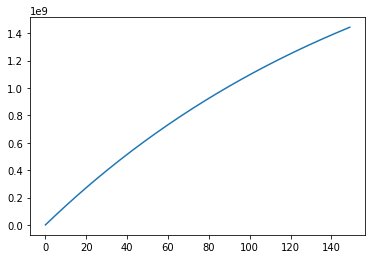

In [93]:
with numpyro.handlers.seed(rng_seed=1):
    x, y, det_rate = SIR_hybrid(T=50, T_future=100, N=1e6, rw_scale=2e-2)
    plt.plot(y)
    
# with numpyro.handlers.seed(rng_seed=1):
#     x, y, det_rate = SIR_hybrid(T=100, N=1e6,rw_scale=1e-2)
#     plt.plot(y)

plt.show()

In [94]:
def plot_samples(samples, plot_fields=['I', 'y'], T=None, t=None, ax=None):
    
    X = samples['x']
    
    if 'x_future' in samples:
        X = np.append(X, samples['x_future'], axis=1)

    T_data = X.shape[1]
    if T is None or T > T_data:
        T = T_data
        
    labels = {
        'S': 'susceptible',
        'I': 'infected',
        'R': 'removed',
        'C': 'confirmed'
    }
    
    fields = {'S': X[:,:T,0],
              'I': X[:,:T,1],
              'R': X[:,:T,2],
              'C': X[:,:T,3]}    
    
    if 'y' in samples:
        y = samples['y']
        
        if 'y_future' in samples:
            y = np.append(y, samples['y_future'], axis=1)

        fields['y'] = y[:, :T]

    fields = {k: fields[k] for k in plot_fields}

    means = {k: v.mean(axis=0) for k, v in fields.items()}
    
    pred_intervals = {k: np.percentile(v, (10, 90), axis=0) for k, v in fields.items()}
    
    # Use pandas to plot means (for better date handling)
    if t is None:
        t = np.arange(T)        

    df = pd.DataFrame(index=t, data=means)
    df.plot(ax=ax)
    
    # Add prediction intervals
    for k, pred_interval in pred_intervals.items():
        ax = ax if ax is not None else plt.gca()
        ax.fill_between(t, pred_interval[0,:], pred_interval[1,:], alpha=0.1)

In [103]:
import os
import sys

parent = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(parent)

import jhu
import covidtracking

US = covidtracking.load_us()

pop = {
    'tot': 3.27e8,
    'MA': 6.902e6,
    'WA': 7.536e6,
    'NY': 8.632e6
}

place = 'NY'

start = pd.Timestamp('2020-03-02')

confirmed = US[place].confirmed[start:]
confirmed_data = confirmed.to_numpy()
#confirmed_data = np.append(confirmed_dat,np.repeat(np.nan,1))
print (confirmed_data)
T = len(confirmed_data)
N = pop[place]
#ili_dat = pd.read_csv('ili.csv')
#ili_dat = pd.read_csv('stateili.csv')
kernel = NUTS(SIR_hybrid)
mcmc = MCMC(kernel, num_warmup=100, num_samples=500, num_chains=1)


init = {
    'I_init': 0.01*N,
    'E_init':0.01*N,
    'gamma': 1/3.5,
    'beta': .95,
    'det_rate' : 0.3,
    'rw' : np.zeros(T),
    'scale_down' : .0001,
    'sigma': 1/3.5
}


print (T)
print (confirmed_data/10**6)

[6.0000e+00 2.2000e+01 3.3000e+01 7.6000e+01 1.0500e+02 1.4200e+02
 1.7300e+02 2.1600e+02 2.1600e+02 4.2100e+02 5.2400e+02 7.2900e+02
 9.5000e+02 1.7000e+03 2.3820e+03 4.1520e+03 7.1020e+03 1.0356e+04
 1.5168e+04 2.0875e+04 2.5665e+04 3.0811e+04 3.7258e+04 4.4635e+04
 5.2318e+04 5.9513e+04 6.6497e+04 7.5795e+04]
28
[6.0000e-06 2.2000e-05 3.3000e-05 7.6000e-05 1.0500e-04 1.4200e-04
 1.7300e-04 2.1600e-04 2.1600e-04 4.2100e-04 5.2400e-04 7.2900e-04
 9.5000e-04 1.7000e-03 2.3820e-03 4.1520e-03 7.1020e-03 1.0356e-02
 1.5168e-02 2.0875e-02 2.5665e-02 3.0811e-02 3.7258e-02 4.4635e-02
 5.2318e-02 5.9513e-02 6.6497e-02 7.5795e-02]


In [104]:
mcmc.run(jax.random.PRNGKey(2), N=N, T=T, confirmed=confirmed_data, det_conc=100, rw_scale = 1e-2, init_params=init)
mcmc.print_summary()
mcmc_samples = mcmc.get_samples()

sample: 100%|██████████| 600/600 [00:52<00:00, 11.37it/s, 1 steps of size 1.18e-38. acc. prob=0.00] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    E_init 172639.98      0.00 172639.98 172639.98 172639.98       nan       nan
    I_init 172639.98      0.00 172639.98 172639.98 172639.98       nan       nan
      beta      2.59      0.00      2.59      2.59      2.59      0.50       nan
     gamma      1.33      0.00      1.33      1.33      1.33       nan       nan
     sigma      1.33      0.00      1.33      1.33      1.33       nan       nan

Number of divergences: 500


In [98]:
print (T)
T_future=7*4
post_pred = Predictive(SIR_hybrid, posterior_samples = mcmc_samples)
post_pred_samples = post_pred(PRNGKey(2), T=T, T_future=T_future, N=N)
post_pred_samples['y'] = post_pred_samples['y']

28


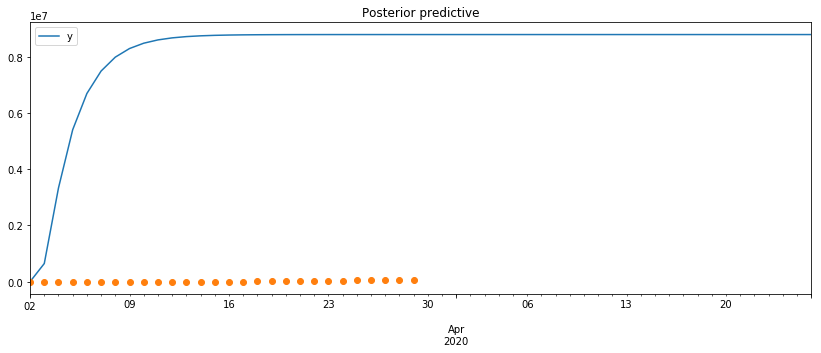

In [100]:
scale = 'notlog'



for T in [7*8]:
    
    t = pd.date_range(start=start, periods=T, freq='D')
    
    fig, ax = plt.subplots(figsize=(14,5))
    plot_samples(post_pred_samples, T=T, t=t, ax=ax, plot_fields=[ 'y'])
    plt.title('Posterior predictive')

    ili = pd.Series(confirmed_data, index=pd.date_range(start=start, periods=len(confirmed_data), freq='D'))
    ili.plot(style='o')
    
    if scale == 'log':
        plt.yscale('log')
        
    #filename = f'figs/{place}_predictive_scale_{scale}_T_{T}.pdf'
    #plt.savefig(filename)
    plt.show()
    

In [ ]:
df